# 프로젝트 목표 :
- RFM분석을 활용한 고객분류 및 타게팅 전략 수립
- 데이터 분석에서 SQL과 Python을 함께 사용하는 법

### 참고) RFM 분석 : 구매 최신성(Recency), 구매 빈도(Frequency)와 구매 가치(Monetary)에 따라 고객들을 여러 그룹으로 나누는 세그먼테이션(segmentation) 방법

    1)Recency: 고객이 마지막으로 구매한 시점을 나타낸다. 최근에 구매한 고객들은 더 자주 구매할 가능성이 높기 때문에, 최신성 점수가 높은지를 고려한다.
    2)Frequency: 특정 기간 동안 고객이 얼마나 자주 우리의 제품이나 서비스를 구매하는지를 나타낸다. 빈번하게 구매를 하는 고객은 더 충성도가 높은 고객일 확률이 높기 때문에, 빈도 점수가 높은지를 고려한다.
    3)Monetary: 고객이 지출한 총 금액을 말한다. 높은 금액을 지불한 고객일수록 더 가치가 높은 충성 고객일 수 있다. 앞으로도 우리 제품과 사이트에 많은 돈을 지불할 수 있는 고객이므로, 가치 점수가 높은지를 함께 고려한다.

Columns (8): InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

(Invoice No. Starts with 'C' = Cancelled order)


# 1. 데이터 불러오기

In [ ]:
#Counting the Number of Datasets by each Columns

SELECT 
  COUNT(InvoiceNo) COUNT_InvoiceNo, 
  COUNT(StockCode) COUNT_StockCode, 
  COUNT(Description) COUNT_Description,
  COUNT(Quantity) COUNT_Quantity, 
  COUNT(InvoiceDate) COUNT_InvoiceDate, 
  COUNT(UnitPrice) COUNT_UnitPrice, 
  COUNT(CustomerID) COUNT_CustomerID, 
  COUNT(Country) COUNT_Country
FROM proven-gasket-411001.modulabs_project.data;

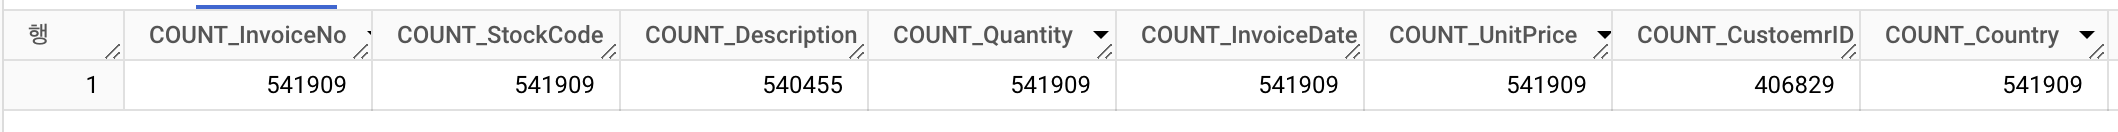

# 2. 데이터 전처리(1) : 결측치 제거

In [ ]:

SELECT
    'InvoiceNo' AS column_name,
    ROUND(SUM(CASE WHEN InvoiceNo IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL 
SELECT
    'Stockcode' AS column_name,
    ROUND(SUM(CASE WHEN Stockcode IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL
SELECT
    'Description' AS column_name,
    ROUND(SUM(CASE WHEN Description IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL
SELECT
    'Quantity' AS column_name,
    ROUND(SUM(CASE WHEN Quantity IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL
SELECT
    'InvoiceDate' AS column_name,
    ROUND(SUM(CASE WHEN InvoiceDate IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL
SELECT
    'UnitPrice' AS column_name,
    ROUND(SUM(CASE WHEN Unitprice IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL
SELECT
    'CustomerID' AS column_name,
    ROUND(SUM(CASE WHEN CustomerID IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data
UNION ALL
SELECT
    'Country' AS column_name,
    ROUND(SUM(CASE WHEN Country IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM proven-gasket-411001.modulabs_project.data

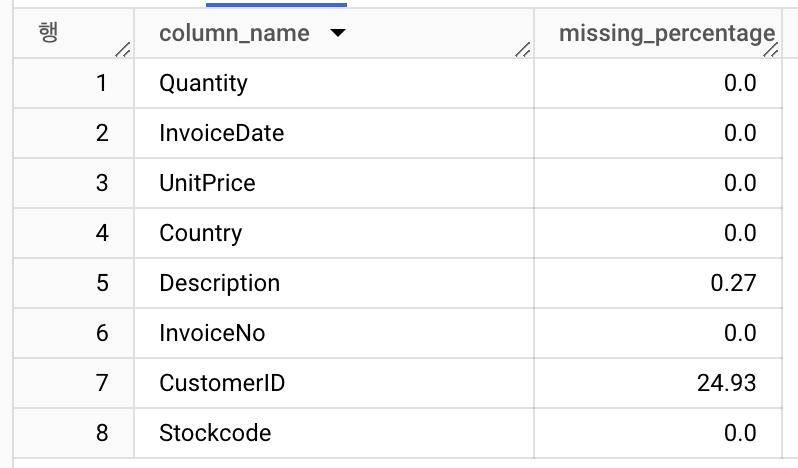

In [2]:
#Remove the CustomerID column, Description 


SELECT DISTINCT Description
FROM proven-gasket-411001.modulabs_project.data
WHERE StockCode ='85123A'

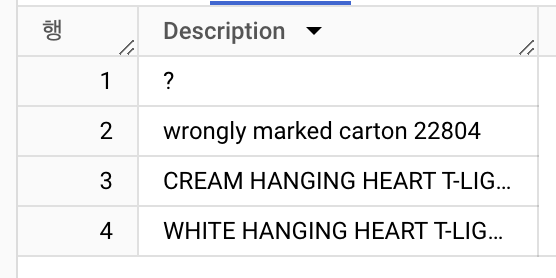

In [ ]:
DELETE FROM proven-gasket-411001.modulabs_project.data
WHERE 
  CustomerID IS NULL 
  OR Description = "?";

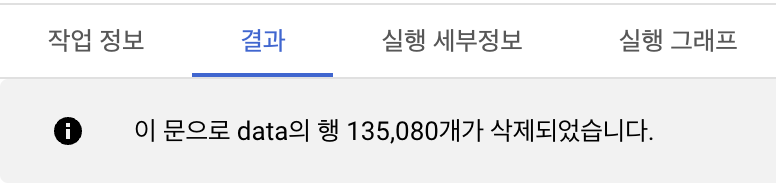

# 3. 데이터 전처리(2) : 중복값 처리

In [ ]:


SELECT *
FROM proven-gasket-411001.modulabs_project.data
GROUP BY InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
HAVING COUNT(*) > 1


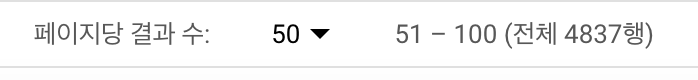

In [ ]:
CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.data AS (
  SELECT DISTINCT *
  FROM proven-gasket-411001.modulabs_project.data)

### Tips

CREATE OR REPLACE TABLE 문에서 어려움에 봉착했으나,
AS 문을 뒤에 붙여줌으로써 간단하게 Duplicate을 없앤 테이블로 대체 가능하다

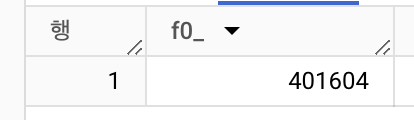

# 4. 데이터 전처리(3) : 오류값 처리

In [ ]:
#고유한 Invoice No.의 갯수


SELECT COUNT(DISTINCT InvoiceNo)
FROM proven-gasket-411001.modulabs_project.data

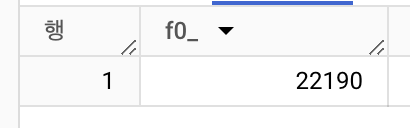

In [ ]:
#Explore Cancelled Transation ('InvoiceNo' starts with 'C')

SELECT *
FROM proven-gasket-411001.modulabs_project.data
WHERE InvoiceNo LIKE 'C%'
LIMIT 100

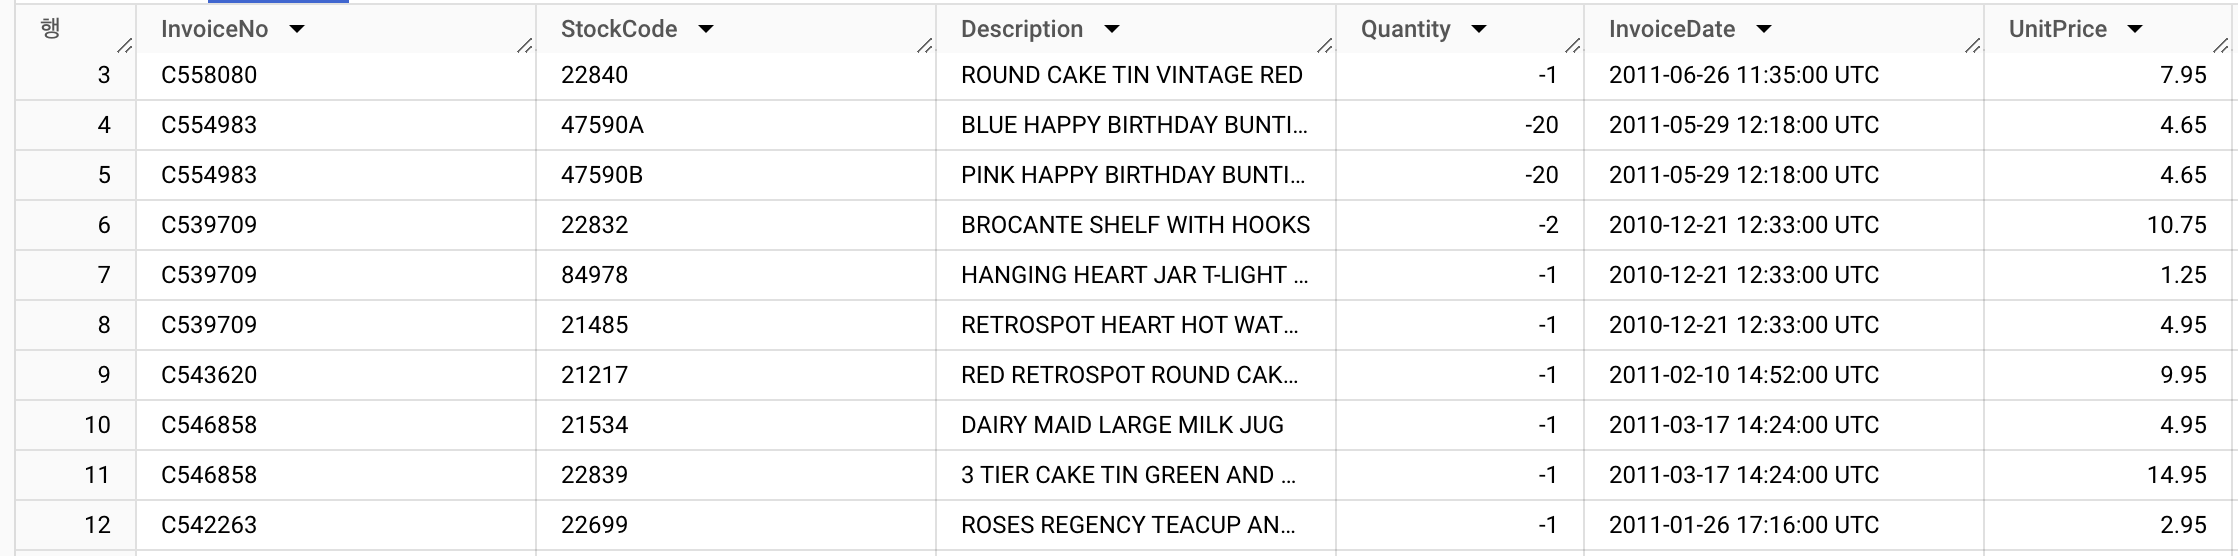

In [ ]:
#Cancelled Transaction Ratio

SELECT ROUND(SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END)/ COUNT(*)*100 ,1) AS Cancelled
FROM proven-gasket-411001.modulabs_project.data

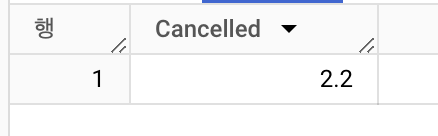

In [ ]:
#Explore 'StockCode'


SELECT COUNT(DISTINCT StockCode)
FROM proven-gasket-411001.modulabs_project.data

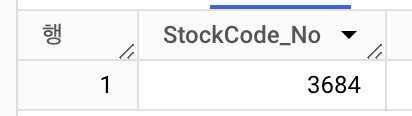

In [ ]:
#Explore Mode of each 'StockCode' to see what product sells the most

SELECT StockCode, COUNT(*) AS sell_cnt
FROM proven-gasket-411001.modulabs_project.data
GROUP BY StockCode
ORDER BY sell_cnt DESC
LIMIT 10;

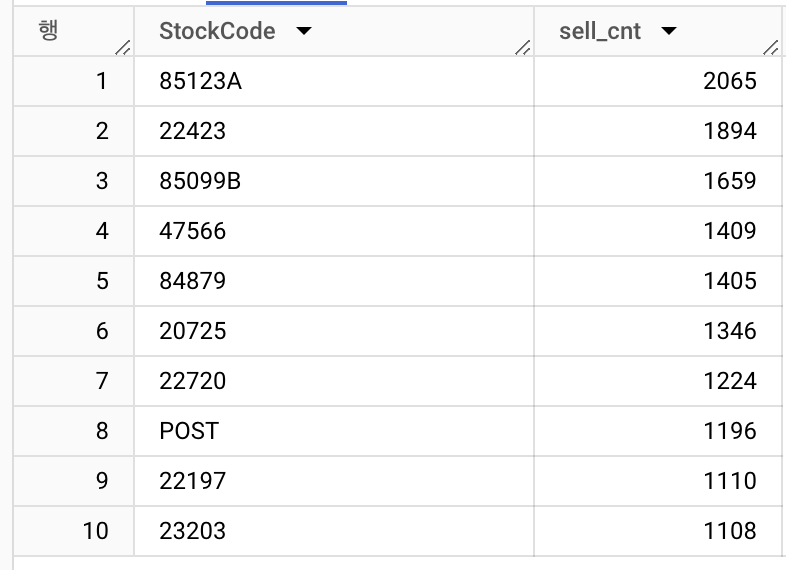

In [ ]:
#Filter Odd StockCode
#Most of the codes are composed of at least 5 numbers

WITH UniqueStockCode AS(
  SELECT DISTINCT StockCode
  FROM proven-gasket-411001.modulabs_project.data
)
SELECT 
  LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count,
  COUNT(*) AS stock_cnt
FROM UniqueStockCode
GROUP BY number_count
ORDER BY stock_cnt DESC


### Tips

* REGEXP_REPLACE(1, 2, 3) : regular expression which processes text
1. Column
2. '[0-9]' : numbers, '[a-z]' : text, '[ㄱ-ㅎ]' : text,  
    '[^0-9] : except numbers 
3. replace 



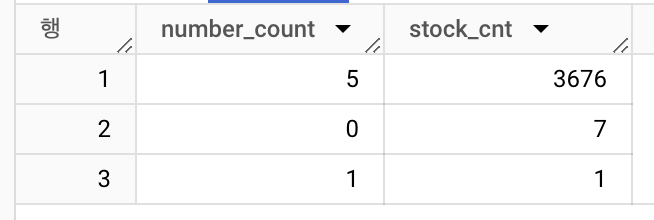

In [ ]:
#Check what kind of Stockcodes have number count 0~ 1

SELECT DISTINCT StockCode, number_count
FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM proven-gasket-411001.modulabs_project.data
)
WHERE number_count BETWEEN 0 AND 1

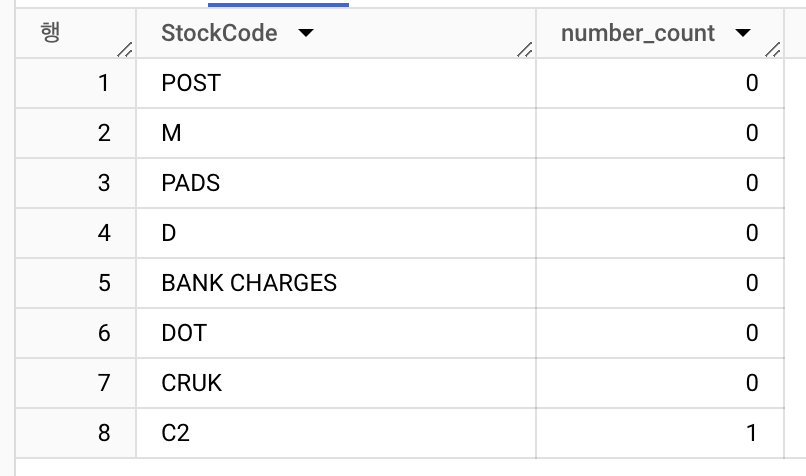

In [ ]:
#Ratio of StockCode with Odd values 

WITH Odd AS (
    SELECT COUNT(StockCode) AS Odd_total
    FROM proven-gasket-411001.modulabs_project.data
    WHERE LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode,r'[0-9]','')) BETWEEN 0 AND 1
),
TOTAL AS (
SELECT COUNT(*) AS total
  FROM proven-gasket-411001.modulabs_project.data
)
SELECT ROUND(Odd_total/Total.total*100,2) AS odd_ratio
FROM Odd, TOTAL

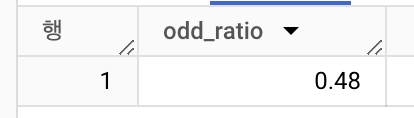


In [ ]:
#Deleting rows with Odd StockCode

DELETE FROM proven-gasket-411001.modulabs_project.data
WHERE StockCode IN
  (SELECT DISTINCT StockCode
  FROM proven-gasket-411001.modulabs_project.data
  WHERE LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode,r'[0-9]','')) BETWEEN 0 AND 1)


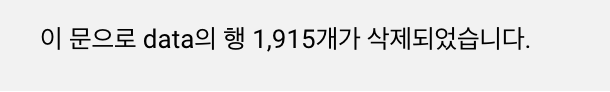

### Tips
DELETE문을 사용하는 대신, 아래와 같은 방법으로 테이블을 대체하였다

In [ ]:
#(다른 시도)
CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.data AS (
  SELECT *
  FROM proven-gasket-411001.modulabs_project.data
  WHERE LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode,r'[0-9]','')) NOT BETWEEN 0 AND 1
)

In [ ]:
#Descprtion별 출현 빈도

SELECT Description, COUNT(*) AS description_cnt
FROM proven-gasket-411001.modulabs_project.data
GROUP BY 1
ORDER BY 2 DESC
LIMIT 30

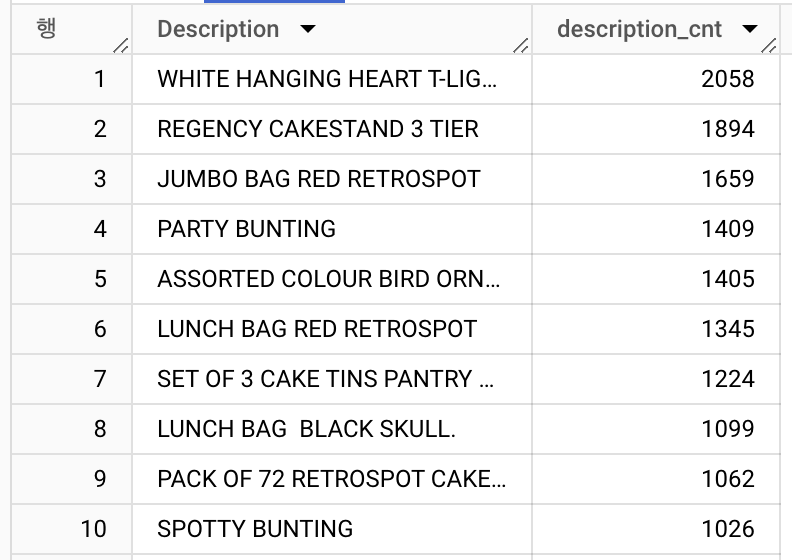

In [ ]:
#대부분이 대문자인 것으로 보이나, 대소문자가 혼합된 스타일의 Description 존재 여부 확인

SELECT DISTINCT Description
FROM proven-gasket-411001.modulabs_project.data
WHERE REGEXP_CONTAINS(Description, r'[a-z]')


### Tips
REGEXP_CONTAINS(Column, 소문자 문자열) : 해당 문자가 포함된 경우의 컬럼값을 도출

In [ ]:
#Remove Rows contains Service-related Description

DELETE
FROM proven-gasket-411001.modulabs_project.data
WHERE Description IN ('Next Day Carriage','High Resolution Image')

In [ ]:
# Change rest of the Descriptions to Uppercase

CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.data AS
SELECT
  * EXCEPT (Description),
  UPPER(Description) AS Description
FROM proven-gasket-411001.modulabs_project.data
)

### Tips

-EXCEPT (Column) : 
bring all the columns of the table exept for certain column
-UPPER(Column), LOWER(Column) AS Column_name : Change case


In [ ]:
#Unit Price

SELECT MIN(UnitPrice) min_price, MAX(UnitPrice) max_price, AVG(UnitPrice) avg_price
FROM proven-gasket-411001.modulabs_project.data

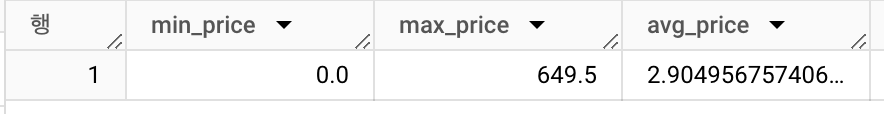

In [ ]:
#Get Quantities where UnitPrice = 0

SELECT 
  COUNT(Quantity) cnt_quantity, 
  MIN(Quantity) min_quantity, 
  MAX(Quantity) max_quantity, 
  AVG(Quantity) avg_quantity
FROM proven-gasket-411001.modulabs_project.data
WHERE UnitPrice = 0;

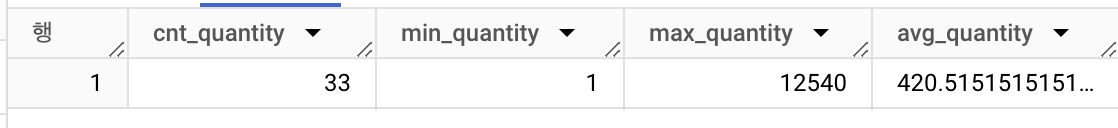

In [ ]:
#Remove the rows with UnitPrice = 0

CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.data AS (
  SELECT *
  FROM proven-gasket-411001.modulabs_project.data
  WHERE UnitPrice != 0
);

# 5. RFM Score

## 1) Recency

### Tips

-DATE(YY, MM, DD)  
-YEAR(full date)  
-MONTH(full date)  
-DAY(full date)

In [ ]:
#Change InvoiceDate type into YYMMDD

SELECT DATE(InvoiceDate) AS InvoiceDay, *
FROM proven-gasket-411001.modulabs_project.data

WITH MaxDate AS (
  SELECT 
  * EXCEPT (InvoiceDate),
  DATE(InvoiceDate) AS InvoiceDay
  FROM proven-gasket-411001.modulabs_project.data
  )

SELECT MAX(InvoiceDay) 
FROM MaxDate

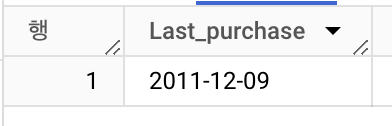

In [ ]:
#Last Purchase Date for each CustomerID

WITH MaxDate AS (
  SELECT 
  * EXCEPT (InvoiceDate),
  DATE(InvoiceDate) AS InvoiceDay
  FROM proven-gasket-411001.modulabs_project.data
  )

SELECT 
  DISTINCT(CustomerID),
  MAX(InvoiceDay) OVER (PARTITION BY CustomerID ORDER BY InvoiceDay DESC) AS InvoiceDay
FROM MaxDate
ORDER BY CustomerID


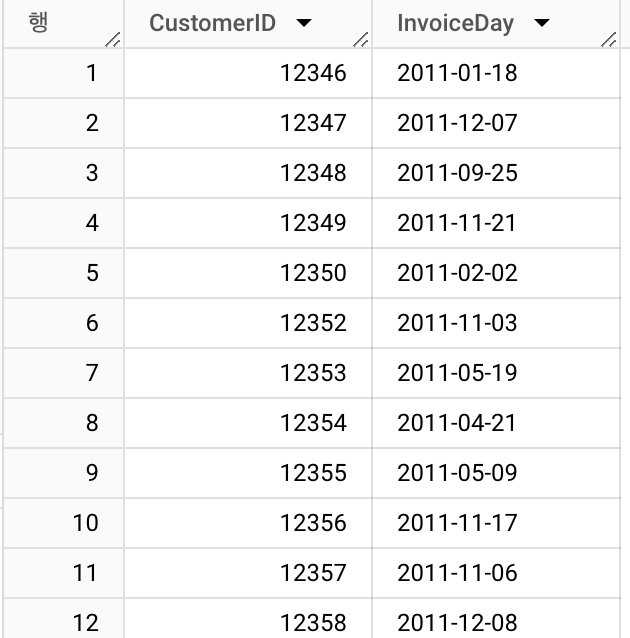

In [ ]:
# Calculate the Gap btw most recent purchase for each customers &  Max purchase date


SELECT
  CustomerID,
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM proven-gasket-411001.modulabs_project.data
  GROUP BY CustomerID
)



### Tips

-Extract : extract certain year, month, day, or hour, minute, second
ex) EXTRACT(DAY FROM -) : extract only DAY information

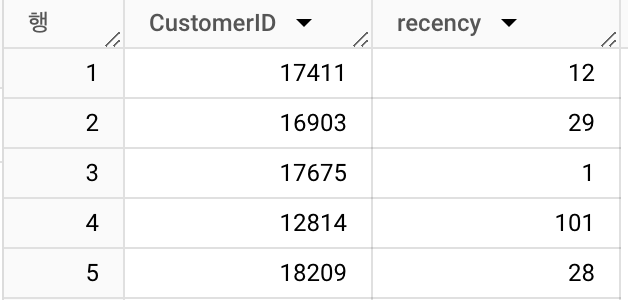

In [ ]:
# Create Recency table

CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.user_r AS (
  SELECT
    CustomerID,
    EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
  FROM (
    SELECT
      CustomerID,
      MAX(DATE(InvoiceDate)) AS InvoiceDay
    FROM proven-gasket-411001.modulabs_project.data
    GROUP BY CustomerID
  )
)


## 2) Frequency

In [ ]:
#Total transactions per customer (based on Distinct invoice numbers)

SELECT
  CustomerID,
  COUNT(DISTINCT InvoiceNo) AS purchase_cnt
FROM proven-gasket-411001.modulabs_project.data
GROUP BY CustomerID


In [ ]:
#Total number of purchased items (Create table)


#Total purchase number
CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.user_rf AS
WITH purchase_cnt AS (   
  SELECT
    DISTINCT(CustomerID),
    COUNT(DISTINCT InvoiceNo) AS purchase_cnt
  FROM proven-gasket-411001.modulabs_project.data
  GROUP BY CustomerID
),

#Total item quantity purchased
item_cnt AS ( 
  SELECT 
    DISTINCT(CustomerID),
    SUM(Quantity) OVER (PARTITION BY CustomerID) AS item_cnt
  FROM proven-gasket-411001.modulabs_project.data
  ORDER BY 1
)

#join tables
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN proven-gasket-411001.modulabs_project.user_r AS ur
  ON pc.CustomerID = ur.CustomerID


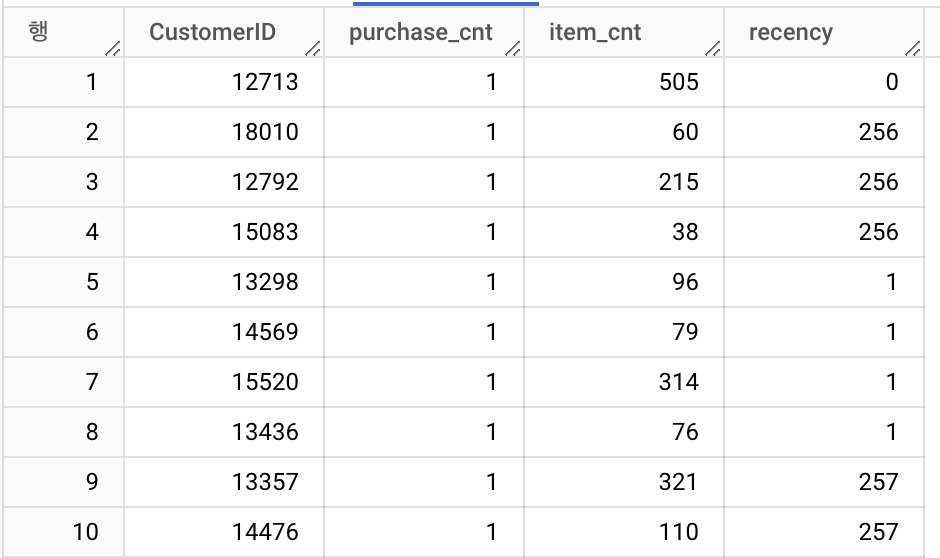

## 3) Monetary

In [ ]:
#Total consumption for each for customers

SELECT 
  CustomerID,
  ROUND(SUM(UnitPrice * Quantity),0) AS user_total
FROM proven-gasket-411001.modulabs_project.data
GROUP BY CustomerID;

In [ ]:
#Average transaction amount for each customers

CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.user_rfm AS
SELECT
  rf.CustomerID AS CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  user_total/purchase_cnt AS user_average
FROM proven-gasket-411001.modulabs_project.user_rf rf
LEFT JOIN (
  SELECT
  CustomerID,
  ROUND(SUM(UnitPrice * Quantity),0) AS user_total
FROM proven-gasket-411001.modulabs_project.data
GROUP BY CustomerID
) ut
ON rf.CustomerID = ut.CustomerID;



#### Complete RFM Table

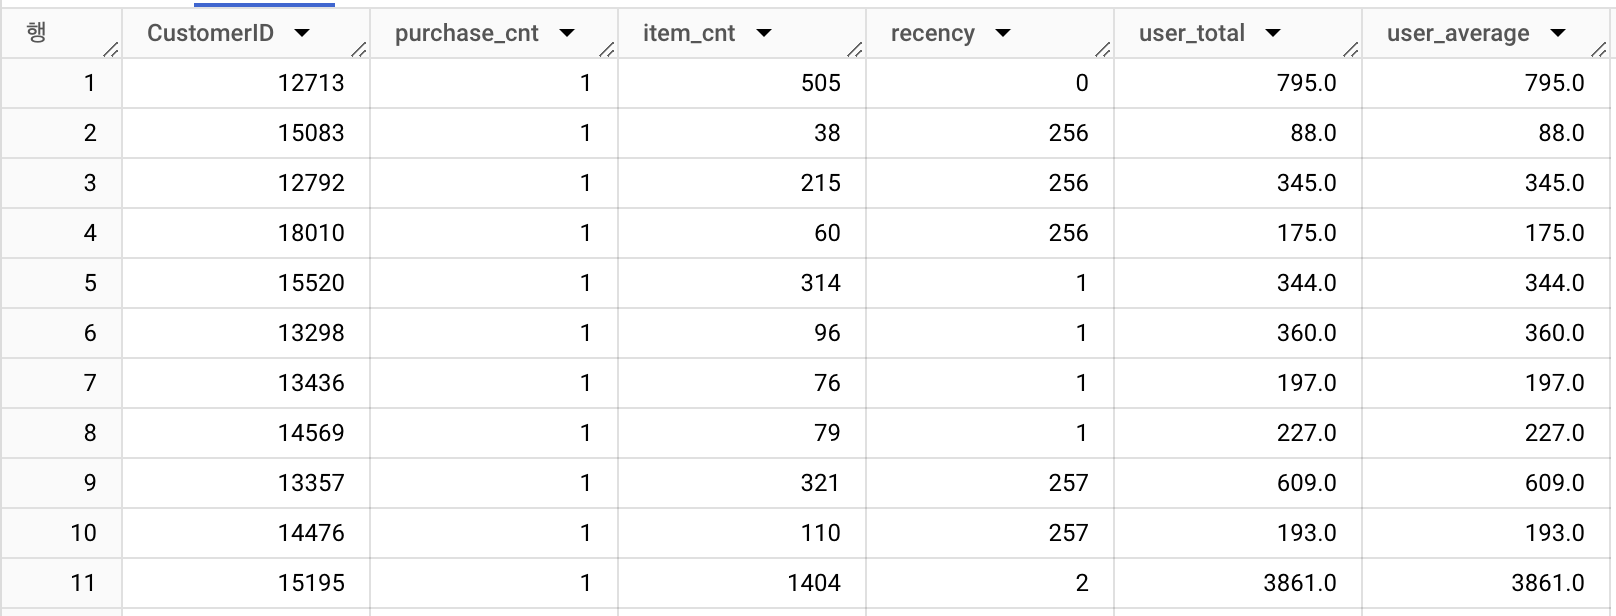

# 6. 추가 Feature 추출
1)구매 제품 다양성  
2)평균 구매 주기  
3)구매 취소 경향성

In [ ]:
#구매 제품 다양성

CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.user_data AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM proven-gasket-411001.modulabs_project.data
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM proven-gasket-411001.modulabs_project.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;

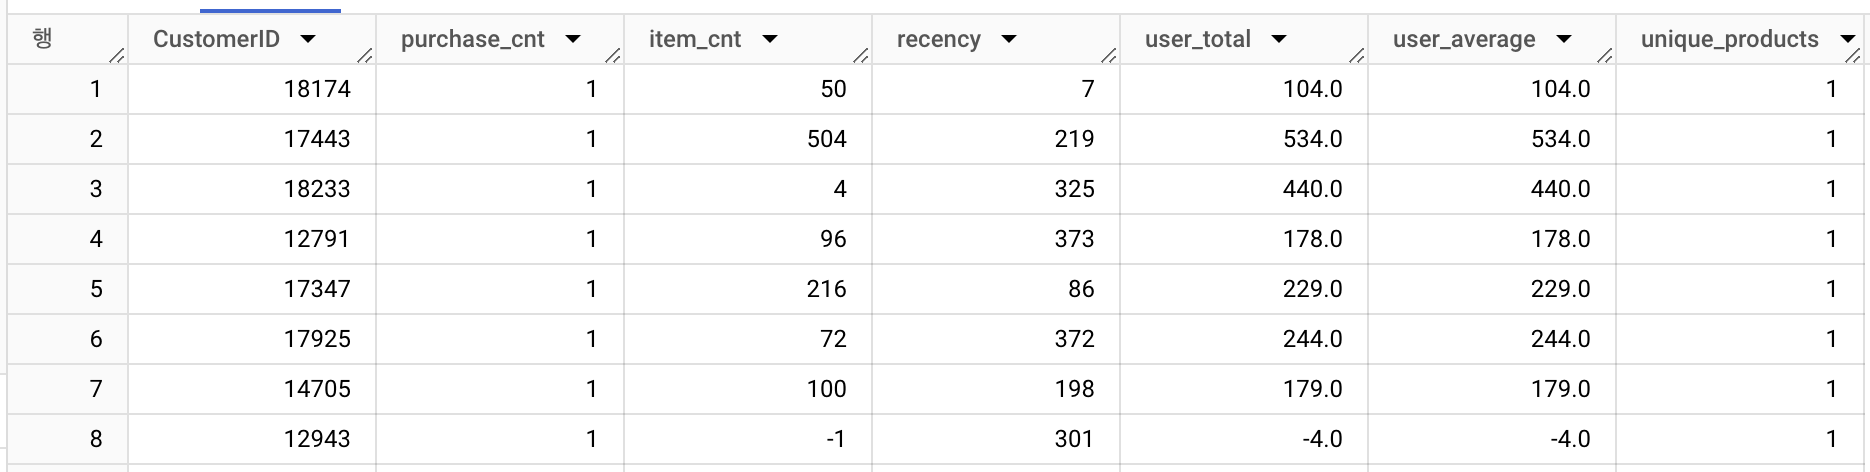

In [ ]:
#평균 구매 주기

CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.user_data AS 
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      proven-gasket-411001.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM proven-gasket-411001.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;


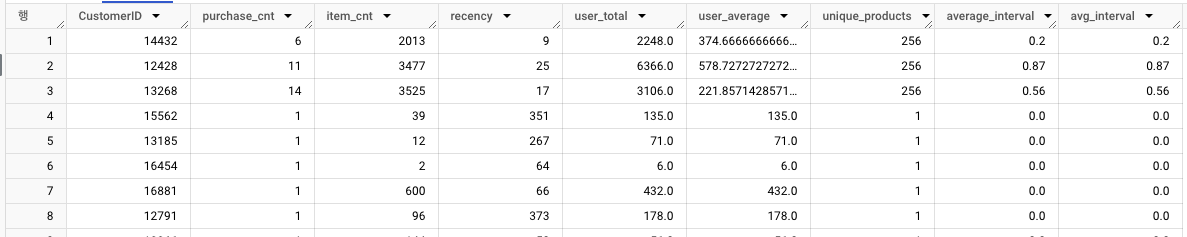

### Tips
열이 중복으로 생겨서, avg_interval을 삭제하는 수식을 적용했다 

ALTER TABLE proven-gasket-411001.modulabs_project.user_data
DROP COLUMN avg_interval;


In [ ]:
#구매 취소 경향성

#cancel frequency
CREATE OR REPLACE TABLE proven-gasket-411001.modulabs_project.user_data AS
WITH TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(InvoiceNo) AS total_transactions,
    SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END) cancel_frequency
  FROM proven-gasket-411001.modulabs_project.data
  GROUP BY CustomerID
)

#cancel rate
SELECT 
  u.*,
  t.* EXCEPT(CustomerID),
  ROUND(cancel_frequency/total_transactions, 2) AS cancel_rate
FROM proven-gasket-411001.modulabs_project.user_data AS u
LEFT JOIN TransactionInfo AS t
ON u.CustomerID = t.CustomerID

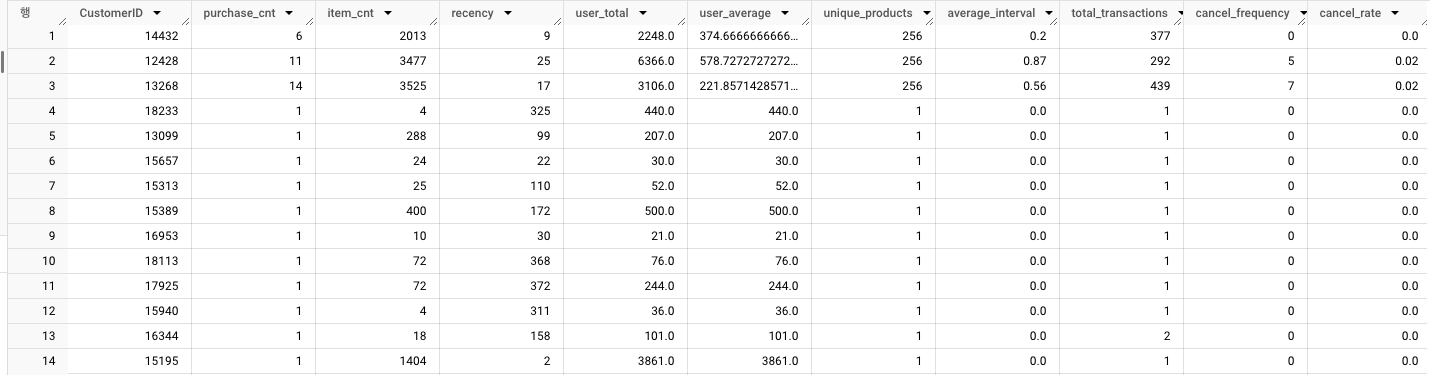

## Tips

-UPDATE 문 : 열의 정보를 업데이트 할 때 사용

위 결과물에서 user_average의 소숫점 자리 처리를 누락하여 update 해주기로 한다
UPDATE(Table Name)
SET column = value, column2 = value2 , ...
WHERE condition

In [ ]:
#수정문

UPDATE proven-gasket-411001.modulabs_project.user_data
SET user_average = ROUND(user_average, 2)
WHERE user_average > 0

Final user_data Table  

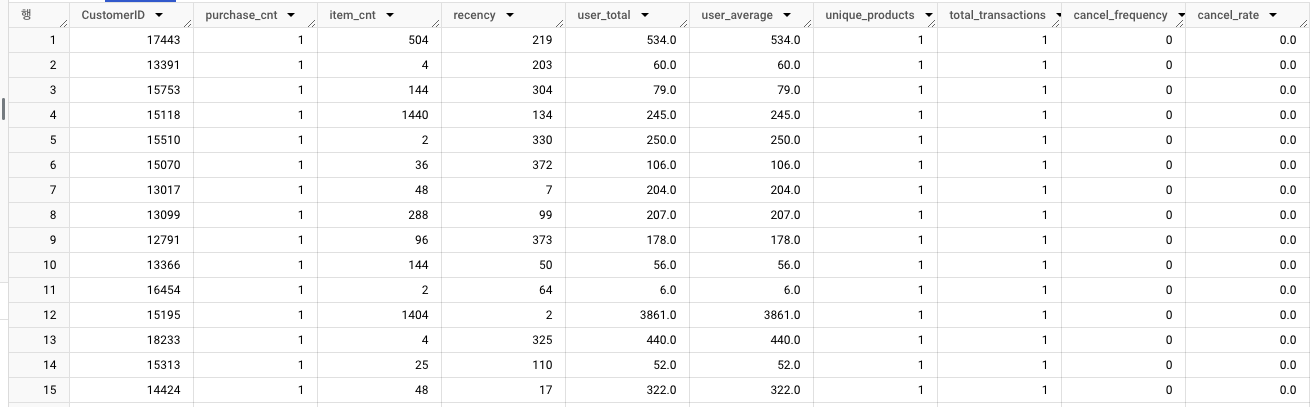

In [8]:
import pandas as pd 
user_data = pd.read_csv('~/aiffel/customer_segmentation/user_data.csv')

In [9]:
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,total_transactions,cancel_frequency,cancel_rate
0,17443,1,504,219,534.0,534.0,1,1,0,0.0
1,13391,1,4,203,60.0,60.0,1,1,0,0.0
2,15753,1,144,304,79.0,79.0,1,1,0,0.0
3,15118,1,1440,134,245.0,245.0,1,1,0,0.0
4,15510,1,2,330,250.0,250.0,1,1,0,0.0


# 회고  
  
배운 점 : SQL 언어를 사용하여, 표를 업데이트하고, 열을 바꾸는 등 변형을 주는 명령어를 배웠다.  
오류값, 중복값, 결측치 등 데이터 속 노이즈를 삭제하는 방법을 배웠다.  
REGEXP라고 하는 정규표현식을 통해, 데이터가 표현되어 있는 형식을 걸러내고, 대체하는 방법을 배웠다.  
주피터노트북을 적극적으로 활용하여 SQL 기록을 남기는 법을 배웠다.

  
잘한 점 : 헷갈리거나 모르는 부분을 적극적으로 검색해서, 새로운 명령어를 대입해보았고, 테이블에서 원하지 않는 결과가 나왔을 경우에 원하는 방식으로 바꿔서 표현하는 법을 익혔다.  또, 데이터로부터 의미있는 결과치를 도출하여 더 직관적인 인사이트를 도출하는 방법을 배웠다.

  
  아쉬운 점 : 아직 완벽히 익숙해지지 않은 부분들 (With 문, Window절 등)을 추가적인 연습을 통해 보충하도록 한다.